# Autoencoder
In this notebook, we are going to be focusing on the autoencoder with an extra decoder in the autoencoder module in PAI-Utils.

## Setup
First, we must import packages and get the Cityscapes dataset.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython.display import Image, display

from paiutils import image
from paiutils import util_funcs
from paiutils import neural_network as nn
from paiutils import autoencoder as ae

# see if using GPU and if so enable memory growth
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Get Cityscapes Dataset
The dataset used here can be downloaded from [here](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/). It is a modified version, which is quicker to download for a demo. The real dataset can be downloaded [here](https://www.cityscapes-dataset.com/)

In [2]:
# Get dataset
dataset_path = 'cityscapes'
dataset = util_funcs.load_directory_datasets(dataset_path, image.load)

dataset2 = {}
for key in dataset:
    dataset2[key] = ([], [])
    for x in dataset[key]:
        real_x = image.shrink_sides(x, rs=256)
        seg_x = image.shrink_sides(x, ls=256)

        real_x = image.resize(real_x, (64, 64))
        seg_x = image.resize(seg_x, (64, 64))
        
        real_x = image.normalize(real_x)
        seg_x = image.normalize(seg_x)

        dataset2[key][0].append(real_x)
        dataset2[key][1].append(seg_x)
dataset = dataset2

data = {
    'train_x': np.array(dataset['train'][0]), 
    'train_y': np.array(dataset['train'][1]),
    'validation_x': np.array(dataset['val'][0]), 
    'validation_y': np.array(dataset['val'][1])
}
del dataset

print(data['train_x'].shape, data['train_y'].shape)
print(data['validation_x'].shape, data['validation_y'].shape)

(2975, 64, 64, 3) (2975, 64, 64, 3)
(500, 64, 64, 3) (500, 64, 64, 3)


## Create the Model
Although we could approach this problem of segmenting the images as purely a supervised learning problem, we will not. Instead, we will first make an autoencoder that can encode the real images. Once we have this trained autoencoder, we will train another decorder on the encoder to output the segmented images.

In [3]:
x0 = keras.layers.Input(shape=data['train_x'][0].shape)
x = nn.conv2d(64, 3, 2)(x0)
x = nn.conv2d(128, 3, 2)(x)
x = nn.conv2d(256, 3, 2)(x)
x = nn.conv2d(512, 3, 2)(x)
output = nn.conv2d(1024, 3, 2)(x)
encoder_model = keras.Model(inputs=x0, outputs=output)
encoder_model.compile(optimizer='adam', loss='mse')
encoder_model.summary()

x0 = keras.layers.Input(shape=(2, 2, 1024))
x = nn.conv2d(1024, 3, 2, transpose=True)(x0)
x = nn.conv2d(512, 3, 2, transpose=True)(x)
x = nn.conv2d(256, 3, 2, transpose=True)(x)
x = nn.conv2d(128, 3, 2, transpose=True)(x)
x = nn.conv2d(64, 3, 2, transpose=True)(x)
output = nn.conv2d(3, 1, 1, activation='softsign')(x)
decoder_model = keras.Model(inputs=x0, outputs=output)
decoder_model.compile(optimizer='adam', loss='mse')
decoder_model.summary()

x0 = keras.layers.Input(shape=(2, 2, 1024))
x = nn.conv2d(1024, 3, 2, transpose=True)(x0)
x = nn.conv2d(512, 3, 2, transpose=True)(x)
x = nn.conv2d(256, 3, 2, transpose=True)(x)
x = nn.conv2d(128, 3, 2, transpose=True)(x)
x = nn.conv2d(64, 3, 2, transpose=True)(x)
output = nn.conv2d(3, 1, 1, activation='softsign')(x)
decoder_model2 = keras.Model(inputs=x0, outputs=output)
decoder_model2.compile(optimizer='adam', loss='mse')
decoder_model2.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1728      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73728     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         294912    
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 256)        

## Train the Model
We can now use the AutoencoderTrainer to train the encoder and decoder models on the real images in the cityscapes dataset.

In [4]:
trainer = ae.AutoencoderExtraDecoderTrainer(
    encoder_model, decoder_model, decoder_model,
    data, include_y_data=False
)
trainer.train(20, batch_size=16)
path = trainer.save('')

Epoch 1/20
186/186 [==============================] - 6s 31ms/step - loss: 0.5753 - val_loss: 0.3290
Epoch 2/20
186/186 [==============================] - 5s 29ms/step - loss: 0.2715 - val_loss: 0.2399
Epoch 3/20
186/186 [==============================] - 5s 29ms/step - loss: 0.1349 - val_loss: 0.1749
Epoch 4/20
186/186 [==============================] - 5s 28ms/step - loss: 0.0695 - val_loss: 0.1239
Epoch 5/20
186/186 [==============================] - 5s 29ms/step - loss: 0.0392 - val_loss: 0.0750
Epoch 6/20
186/186 [==============================] - 5s 28ms/step - loss: 0.0266 - val_loss: 0.0582
Epoch 7/20
186/186 [==============================] - 5s 28ms/step - loss: 0.0214 - val_loss: 0.0517
Epoch 8/20
186/186 [==============================] - 5s 28ms/step - loss: 0.0195 - val_loss: 0.0456
Epoch 9/20
186/186 [==============================] - 5s 28ms/step - loss: 0.0185 - val_loss: 0.0406
Epoch 10/20
186/186 [==============================] - 5s 28ms/step - loss: 0.0178 - val_lo

The encoder is now trained, so we can now train the extra decoder.

In [5]:
trainer.train_extra_decoder(20, batch_size=16)
path = trainer.save('')

Epoch 1/20
186/186 [==============================] - 4s 21ms/step - loss: 0.0981 - val_loss: 0.3465
Epoch 2/20
186/186 [==============================] - 4s 20ms/step - loss: 0.0717 - val_loss: 0.2240
Epoch 3/20
186/186 [==============================] - 4s 20ms/step - loss: 0.0631 - val_loss: 0.1433
Epoch 4/20
186/186 [==============================] - 4s 20ms/step - loss: 0.0547 - val_loss: 0.0980
Epoch 5/20
186/186 [==============================] - 4s 20ms/step - loss: 0.0467 - val_loss: 0.0868
Epoch 6/20
186/186 [==============================] - 4s 20ms/step - loss: 0.0396 - val_loss: 0.0847
Epoch 7/20
186/186 [==============================] - 4s 20ms/step - loss: 0.0340 - val_loss: 0.0860
Epoch 8/20
186/186 [==============================] - 4s 20ms/step - loss: 0.0296 - val_loss: 0.0873
Epoch 9/20
186/186 [==============================] - 4s 21ms/step - loss: 0.0261 - val_loss: 0.0882
Epoch 10/20
186/186 [==============================] - 4s 20ms/step - loss: 0.0233 - val_lo

## Test the Model
We will test the model by using the AutoencoderPredictor to load the saved model and weights

In [6]:
path = 'trained_model2'
encoder = nn.Predictor(
    path, 'encoder_model_weights.h5', 'encoder_model.json'
)
decoder = nn.Predictor(
    path, 'decoder_model2_weights.h5', 'decoder_model2.json'
)

model
Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
functional_1 (Functional)    (None, 2, 2, 1024)        6276544   
_________________________________________________________________
functional_3 (Functional)    (None, 64, 64, 3)         15712204  
Total params: 21,988,748
Trainable params: 21,980,806
Non-trainable params: 7,942
_________________________________________________________________

encoder_model
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1728  

We will display the real image on the left, the real segemented image in the middle, and the predicted segemented image on the right.

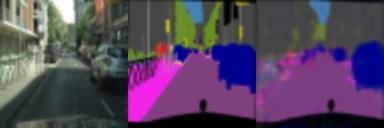

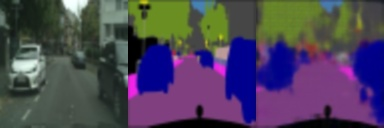

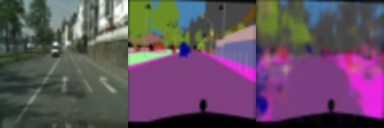

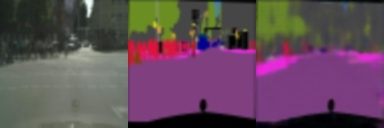

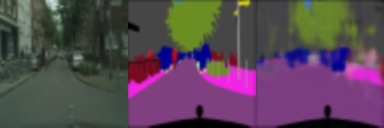

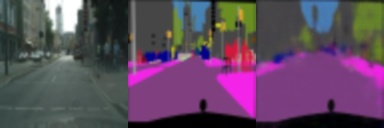

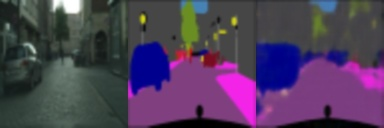

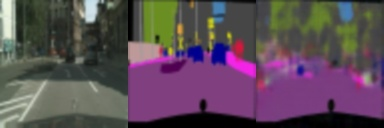

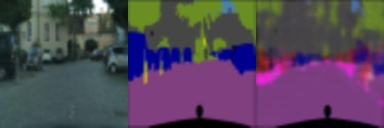

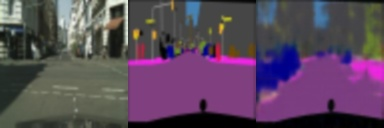

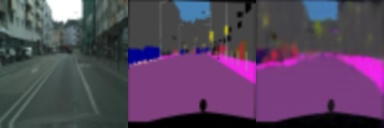

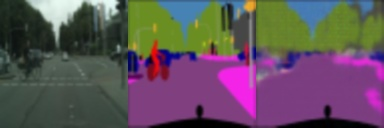

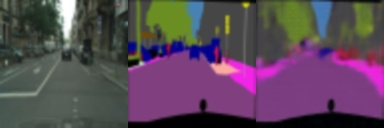

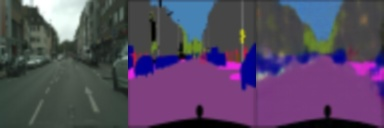

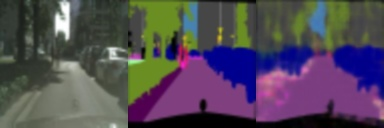

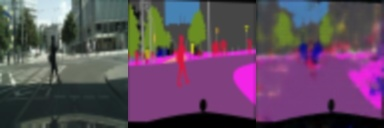

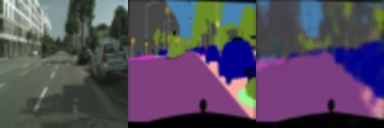

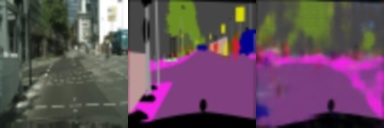

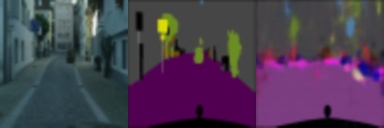

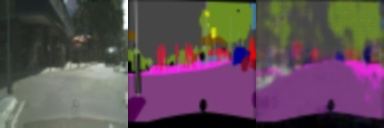

In [7]:
%matplotlib inline
for _ in range(20):
    ndx = np.random.randint(len(data['validation_x']))
    x = data['validation_x'][ndx]
    y = data['validation_y'][ndx]
    
    encoding = encoder.predict(x)
    pred = decoder.predict(encoding)
    pred = image.denormalize(pred)
    
    x = image.denormalize(x)
    y = image.denormalize(y)
    img = np.hstack([
        image.pyr(x, 1), image.pyr(y, 1), image.pyr(pred, 1)
    ])
    ret = image.cv2.imencode('.jpg', img)[1]
    display(Image(data=ret))

The model does not perform that well. The model did not work well mainly because this model design was not intended to be used for this type of task (the supervised method probably could of produced better results), but because of a lack of access to an appropriate dataset this will at least suffice in showing how to use the autoencoder with an extra decoder. For better results, we could try a generative adversarial network (GAN) method.